In [1]:
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tools import eval_summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

/home/aiden/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


device(type='cuda', index=0)

In [2]:
print(os.getcwd())

base_path = '.'

df_train = pd.read_csv(os.path.join(base_path , 'input/train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(base_path , 'input/public_test.csv'), index_col=0)
df_test['smishing'] = -1

df_fea = pd.concat([df_train, df_test])
df_fea.shape

/home/aiden/src/dacon_14


(297571, 3)

In [3]:
train_size = len(df_train)
print(train_size)

cat_cols = []
# fea_cols = tfidf_cols + cat_cols + cnt_cols
# fea_cols = cnt_cols + cat_cols
# fea_cols = tfidf_cols + cat_cols
# len(fea_cols)

295945


#### Load Data

In [4]:
# merged_ts = '20191231T113708_5499'
# merged_ts = '20191231T162533_2022'
# merged_ts = '20191231T165424_6099'
# merged_ts = '20191231T111228_8180'
# merged_ts = '20200101T184353_5853'

# merged_ts = '20200102T005929_6546_128_49980' # 984
merged_ts = '20200102T015155_8438_128_49980'


train_path = 'data/df_merged_{}_train.pkl'.format(merged_ts)
test_path = 'data/df_merged_{}_test.pkl'.format(merged_ts)
dict_path = 'data/df_merged_{}_fea_dict.pkl'.format(merged_ts)

df_model = joblib.load(train_path)  
df_test = joblib.load(test_path) 
fea_dict = joblib.load(dict_path)

print('model_set\n', df_model['smishing'].value_counts())

df_model.drop('morphs_128_idx', axis=1, inplace=True)
df_test.drop('morphs_128_idx', axis=1, inplace=True)


model_set
 0    277242
1     18703
Name: smishing, dtype: int64


In [5]:
fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'morphs_128_idx']]
len(fea_cols)

8437

#### Params

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')

initscore_filename = ''
params = {
    'boosting':'gbdt',
#     'boosting':'dart',
    'num_leaves': 7, 
#     'max_depth': 5,
    'objective': 'binary',
    'metric':'auc',
    'num_threads': 16,
    'learning_rate': 0.005,
#     'is_unbalance': True,
    'scale_pos_weight':200,
    'bagging_fraction':0.5,
    'bagging_freq':10,
    'feature_fraction':0.5,
    'initscore_filename':initscore_filename,
#     'lambda_l1':200,
#     'lambda_l2':2000,
    'device_type':'gpu',
}

data_params = {
    'max_bin':128,
#     'enable_bundle': False,
}
num_round = 8000



In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295945 entries, 0 to 336378
Columns: 8438 entries, smishing to tfidf_pos_word_22_0499
dtypes: float16(8393), int16(44), int64(1)
memory usage: 4.7 GB


In [8]:
df_model = df_model.reset_index()

In [9]:
df_model

,id,smishing,EC,EF,EP,ETM,ETN,IC,JC,JKB,...,tfidf_pos_word_22_0490,tfidf_pos_word_22_0491,tfidf_pos_word_22_0492,tfidf_pos_word_22_0493,tfidf_pos_word_22_0494,tfidf_pos_word_22_0495,tfidf_pos_word_22_0496,tfidf_pos_word_22_0497,tfidf_pos_word_22_0498,tfidf_pos_word_22_0499
0,0,0,0,2,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2,5,4,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,1,5,5,7,2,0,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,2,1,1,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295940,336373,0,5,4,8,7,2,0,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295941,336375,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295942,336376,0,5,2,3,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295943,336377,0,3,2,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Train

In [10]:
pred_csv = []
fea_size = -1
try_cnt = 1

for t in tqdm_notebook(range(try_cnt), total=try_cnt, desc = 'Try'):
    fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'score']]
    
    if fea_size > 0:
        fea_cols = list(set(np.random.choice(fea_cols, fea_size)))
        print(t, len(fea_cols), fea_cols[:100])
    else:
        print(t, len(fea_cols))

    [df_model.drop(c, axis=1, inplace=True) for c in df_model.columns if 'smishing_' in c]
    [df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

#     X = df_model[fea_cols].values
#     y = df_model['smishing'].values

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, random_state=8405)
    cnt = 0
    
#     train_data = lgb.Dataset(X, label=y, feature_name=fea_cols, categorical_feature=cat_cols, 
#                              free_raw_data=False, params=data_params)

    # for train_index, valid_index in skf.split(X, y):
    for train_index, valid_index in tqdm_notebook(skf.split(df_model[fea_cols].values, df_model['smishing'].values), total=n_splits, desc = 'CV'):
        cnt = cnt + 1
        print('\n', t, '*' * 20, cnt, '*' * 20)
        
        train_set = lgb.Dataset(df_model.loc[train_index, fea_cols].values, 
                                 label=df_model.loc[train_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)
        
        valid_set = lgb.Dataset(df_model.loc[valid_index, fea_cols].values, 
                                 label=df_model.loc[valid_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)

#         train_set = train_data.subset(train_index, params=data_params).construct()
#         valid_set = train_data.subset(valid_index, params=data_params).construct()
        print('train_set', np.unique(train_set.get_label(), return_counts=True))
        print('valid_set', np.unique(valid_set.get_label(), return_counts=True))

        bst = lgb.train(params, train_set, num_round, categorical_feature=cat_cols,
                        early_stopping_rounds=300, 
                        valid_sets=[train_set, valid_set],
                        verbose_eval=200,
                        # init_model=init_model,
                       )

        print('Best Iteration:', bst.best_iteration)
        pred_tag = 'smishing_{}_{}__{}'.format(t, cnt, bst.best_iteration)

        renamed_cols = [fea_dict[c] if c in fea_dict.keys() else c for c in fea_cols]

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='split'))}
        print('split:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_split.pkl'.format(model_ts, pred_tag))

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='gain'))}    
        print('gain:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_gain.pkl'.format(model_ts, pred_tag))

        df_model['score'] = bst.predict(df_model[fea_cols].values)    
        df_model[['score']].to_csv('submit/{}_{}_lgb_score.csv'.format(model_ts, pred_tag), index=True)
        print('model\n', eval_summary(df_model['smishing'].values, df_model['score'].values, cut_off=0.5))
        
        df_test['smishing'] = bst.predict(df_test[fea_cols].values)    
        df_test[['smishing']].to_csv('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag), index=True)
        pred_csv.append('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag))
        
        del train_set, valid_set
        gc.collect()


0 8437



 0 ******************** 1 ********************
train_set (array([0, 1]), array([221793,  14962]))
valid_set (array([0, 1]), array([55449,  3741]))
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.999958	valid_1's auc: 0.999671
[400]	training's auc: 0.999994	valid_1's auc: 0.999795
[600]	training's auc: 0.999997	valid_1's auc: 0.999884
[800]	training's auc: 0.999999	valid_1's auc: 0.999934
[1000]	training's auc: 0.999999	valid_1's auc: 0.999958
[1200]	training's auc: 1	valid_1's auc: 0.999975
[1400]	training's auc: 1	valid_1's auc: 0.999984
[1600]	training's auc: 1	valid_1's auc: 0.999987
[1800]	training's auc: 1	valid_1's auc: 0.999991
[2000]	training's auc: 1	valid_1's auc: 0.999991
[2200]	training's auc: 1	valid_1's auc: 0.999994
[2400]	training's auc: 1	valid_1's auc: 0.999995
[2600]	training's auc: 1	valid_1's auc: 0.999996
[2800]	training's auc: 1	valid_1's auc: 0.999997
[3000]	training's auc: 1	valid_1's auc: 0.999997
[3200]	training's auc: 1

[1400]	training's auc: 1	valid_1's auc: 0.999934
[1600]	training's auc: 1	valid_1's auc: 0.999948
[1800]	training's auc: 1	valid_1's auc: 0.999961
[2000]	training's auc: 1	valid_1's auc: 0.999967
[2200]	training's auc: 1	valid_1's auc: 0.999969
[2400]	training's auc: 1	valid_1's auc: 0.999971
[2600]	training's auc: 1	valid_1's auc: 0.999972
[2800]	training's auc: 1	valid_1's auc: 0.999973
[3000]	training's auc: 1	valid_1's auc: 0.999975
[3200]	training's auc: 1	valid_1's auc: 0.999976
[3400]	training's auc: 1	valid_1's auc: 0.999982
[3600]	training's auc: 1	valid_1's auc: 0.999985
[3800]	training's auc: 1	valid_1's auc: 0.999985
[4000]	training's auc: 1	valid_1's auc: 0.999985
Early stopping, best iteration is:
[3777]	training's auc: 1	valid_1's auc: 0.999985
Best Iteration: 3777
split: [('tfidf_pos_word_22_0028_xxx 은행', 857), ('tfidf_pos_char_11_0000_ ', 421), ('tfidf_word_11_1263_올림', 385), ('tfidf_word_11_0307_광고', 296), ('tfidf_word_11_1516_전화', 279)]
gain: [('cnt_0715_자', 9798872.

In [11]:
# y_true = df_model['smishing'].values
# y_score = df_model[[c for c in df_model.columns if 'smishing_' in c]].mean(axis=1)

# print('agg model\n', eval_summary(y_true, y_score, cut_off=0.5))

In [12]:
# df_model[(y_score <= 0.5) & (y_true == 1)]['text']

In [13]:
# df_model[(y_score > 0.5) & (y_true == 0)]['text']

In [14]:
print(len(pred_csv))

df_submit = pd.concat([pd.read_csv(csv, index_col=0) for csv in pred_csv], axis=1)

5


In [15]:
df_submit = df_test[['smishing']]
df_submit['smishing'] = 0
for csv in pred_csv:
    print(csv)
    df = pd.read_csv(csv, index_col=0)
    df_submit['smishing'] = df_submit['smishing'] + df['smishing']
    c = csv.split('__')[0][-1]
    df_submit['smishing_{}'.format(c)] = df['smishing']
#     display(df.head())
df_submit['smishing'] = df_submit['smishing'] / len(pred_csv)

submit/20200102T020750_smishing_0_1__4845_lgb.csv
submit/20200102T020750_smishing_0_2__4123_lgb.csv
submit/20200102T020750_smishing_0_3__4820_lgb.csv
submit/20200102T020750_smishing_0_4__2975_lgb.csv
submit/20200102T020750_smishing_0_5__3777_lgb.csv


In [16]:
pred_cols = [c for c in df_submit.columns if 'smishing_' in c]
pred_cols.remove('smishing_1')
pred_cols.remove('smishing_2')
df_submit['std'] = df_submit[pred_cols].std(axis=1)
df_submit['median'] = df_submit[pred_cols].median(axis=1)

In [17]:
df_std = df_submit[df_submit['std'] < 1]
print(df_std.shape)
df_std.sort_values('std', ascending=False).head(30)

(1626, 8)


,smishing,smishing_1,smishing_2,smishing_3,smishing_4,smishing_5,std,median
id,,,,,,,,
341227,0.706087,0.679118,0.901728,0.981549,0.871519,0.096519,0.482357,0.871519
340046,0.427041,0.032274,0.334214,0.121047,0.854306,0.793363,0.406897,0.793363
341349,0.470899,0.085766,0.611003,0.214015,0.954856,0.488858,0.374508,0.488858
340592,0.267926,0.009460,0.029901,0.051133,0.484391,0.764747,0.359527,0.484391
340056,0.373374,0.056993,0.170552,0.132636,0.726873,0.779817,0.359343,0.726873
341620,0.564389,0.519732,0.182455,0.855915,0.310487,0.953353,0.346473,0.855915
340361,0.263704,0.061647,0.155459,0.029228,0.356773,0.715411,0.343208,0.356773
341477,0.244879,0.141601,0.021571,0.715319,0.121179,0.224723,0.317387,0.224723
341365,0.512334,0.117621,0.628527,0.322624,0.943968,0.548930,0.314467,0.548930


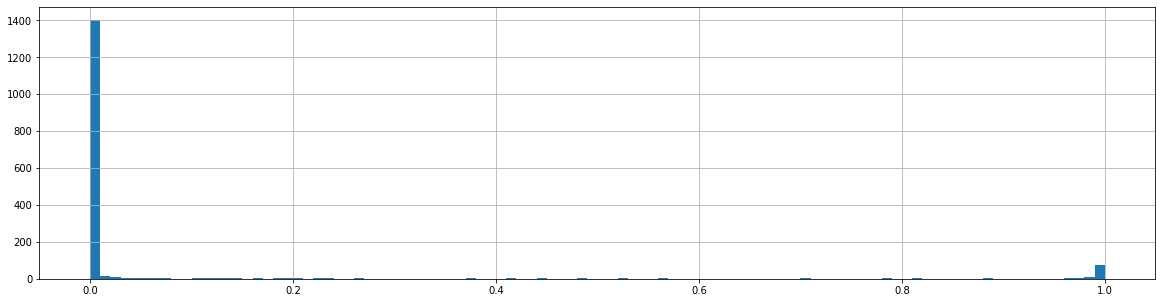

In [18]:
df_submit['smishing'].hist(bins=100, figsize=(20, 5))

In [19]:
(df_submit['smishing'] * 10).astype(int).value_counts(sort=False)

0    1451
1      28
2      11
3       6
4      12
5       5
6       2
7       8
8       9
9      94
Name: smishing, dtype: int64

In [20]:
print(model_ts)
df_submit[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)

20200102T020750


In [21]:
# print(len(pred_cols))
# df_test['pred_max'] = df_test[pred_cols].max(axis=1)
# df_test['pred_min'] = df_test[pred_cols].min(axis=1)
# df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
# df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

# df_test['smishing'] = df_test['pred_mean']

3


KeyError: "None of [Index(['smishing_3', 'smishing_4', 'smishing_5'], dtype='object')] are in the [columns]"

In [ ]:
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [ ]:
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

In [ ]:
# for c in pred_cols:
#     print(c)
#     display((df_test[c] * 10).astype(int).value_counts(sort=False))

In [ ]:
model_ts

In [ ]:
df_test['smishing'] = df_test['smishing']
df_test[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)


In [ ]:
# df_test['smishing'] = df_test['pred_mean']
# df_test[['smishing']].to_csv('submit/{}_lgb.csv'.format(model_ts), index=True)
# # df_test[['id', 'smishing', 'text']].sort_values('smishing', ascending=False).to_csv('{}_text.csv'.format(model_ts), index=False)
